In [1]:
%load_ext autoreload
%autoreload 2

from data_prep import DataPreparation, filtering_data
from lstm import LSTMModelTrainerAttention
from rf import RandomForestTrainer
from lgbm import LightGBMTrainer
from catboost_trainer import CatBoostTrainer
import os
import dill as pickle
import numpy as np
import pandas as pd
from analysis import plot_correlation_heatmap, get_ETO_DEP
from lstm import LSTMModelTrainerAttention, calculate_and_plot_errors#, LSTMModelTrainer

import warnings
warnings.simplefilter(action='ignore')

c:\Users\iLabs_6\anaconda3\envs\texml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
extended_df = pd.read_csv(r"C:\Users\iLabs_6\Documents\Tex\allwithCBAS\extended-atot-5min-ko2.csv")
extended_df['distance'] = extended_df['distance'].astype(float)
extended_df['atfmdelay'] = extended_df['atfmdelay'].astype(float)
cols = extended_df.columns.tolist()
datetime_cols = ['ETOT', 'EOBT', 'ETA', 'cbasentry', 'TSAT', 'TOBT']
timedelta_cols =[col for col in extended_df.columns if 'CBAS' in col]
for col in datetime_cols:
    extended_df[col] = pd.to_datetime(extended_df[col], errors='coerce')
for col in timedelta_cols:
    extended_df[col] = pd.to_timedelta(extended_df[col], errors='coerce')


X, y, colnames = filtering_data(extended_df, airport ='EHAM', save=True)
X = X.drop(['ADES_EHAM', 'ADESLong', 'ADESLat', 'cbasentry'], axis =1)
X.describe()

,distance,cap_DEP,cap_DES,t_to_atot_Tmin_-300,atfmdelay_Tmin_-300,regulations_Tmin_-300,cobt_delay_Tmin_-300,eflighttime_Tmin_-300,visibility_Tmin_-300,ko1_Tmin_-300,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,sin_ETOT,cos_ETOT,sin_ETA,cos_ETA
count,70569.000000,70569.000000,70569.000000,70569.000000,70569.000000,70569.0,70569.000000,70569.000000,70569.000000,70569.000000,...,70569.000000,70569.000000,70569.000000,70569.000000,70569.000000,70569.000000,70569.000000,7.056900e+04,70569.000000,7.056900e+04
mean,9573.249006,0.037667,0.049570,291.932373,0.089342,0.0,4.295994,89.978787,7457.270189,0.972467,...,0.142428,0.141578,0.144950,0.148904,0.127861,0.147742,-0.019010,-3.931527e-01,-0.153451,-3.561073e-01
std,4409.623348,0.018362,0.016133,24.120520,0.441186,0.0,18.229205,44.089621,3396.874006,5.157033,...,0.349491,0.348619,0.352053,0.355996,0.333937,0.354846,0.779272,4.876638e-01,0.747816,5.389093e-01
min,1190.211866,0.000000,0.000000,173.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00
25%,4949.190326,0.024096,0.040000,284.000000,0.000000,0.0,0.000000,62.000000,4000.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.854912,-8.660254e-01,-0.891007,-8.616292e-01
50%,9693.166957,0.036290,0.050000,296.000000,0.000000,0.0,0.000000,81.000000,10000.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.056693,-4.809888e-01,-0.382683,-4.226183e-01
75%,13801.321265,0.050000,0.060000,303.000000,0.000000,0.0,0.000000,121.000000,10000.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.843391,-1.836970e-16,0.652760,6.123234e-17
max,17013.465682,0.131579,0.110000,797.200000,15.350000,0.0,561.000000,328.000000,10000.000000,118.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00


In [4]:
data_prep = DataPreparation()


X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, time_horizons, cbaslabels = data_prep.fit_transform_data(X, y)



skip=['CBAS', 'cbas', 'eobt', 'atot', 'wspeed', 'wdirec', 'wguts']
time_varying_columns=['t_to_atot_Tmin_-300', 'atfmdelay_Tmin_-300', 'regulations_Tmin_-300', 'cobt_delay_Tmin_-300', 'eflighttime_Tmin_-300', 'visibility_Tmin_-300', 'ko1_Tmin_-300', 'ko2_Tmin_-300', 'TSATdelay_Tmin_-300', 'TOBTdelay_Tmin_-300', 'etodepdelay_Tmin_-300', 'timetoCBAS_Tmin_-300', 'offblock_Tmin_-300', 'fltstate_SI_Tmin_-300', 'fltstate_FI_Tmin_-300', 'fltstate_other_Tmin_-300', 'modeltyp_ACT_Tmin_-300', 'modeltyp_CAL_Tmin_-300', 'modeltyp_EST_Tmin_-300', 't_to_atot_Tmin_-295', 'atfmdelay_Tmin_-295', 'regulations_Tmin_-295', 'cobt_delay_Tmin_-295', 'eflighttime_Tmin_-295', 'visibility_Tmin_-295', 'ko1_Tmin_-295', 'ko2_Tmin_-295', 'TSATdelay_Tmin_-295', 'TOBTdelay_Tmin_-295', 'etodepdelay_Tmin_-295', 'timetoCBAS_Tmin_-295', 'offblock_Tmin_-295', 'fltstate_SI_Tmin_-295', 'fltstate_FI_Tmin_-295', 'fltstate_other_Tmin_-295', 'modeltyp_ACT_Tmin_-295', 'modeltyp_CAL_Tmin_-295', 'modeltyp_EST_Tmin_-295', 't_to_ato

Earliest Pattern: _Tmin_-300
Latest Pattern: _Tmin_0


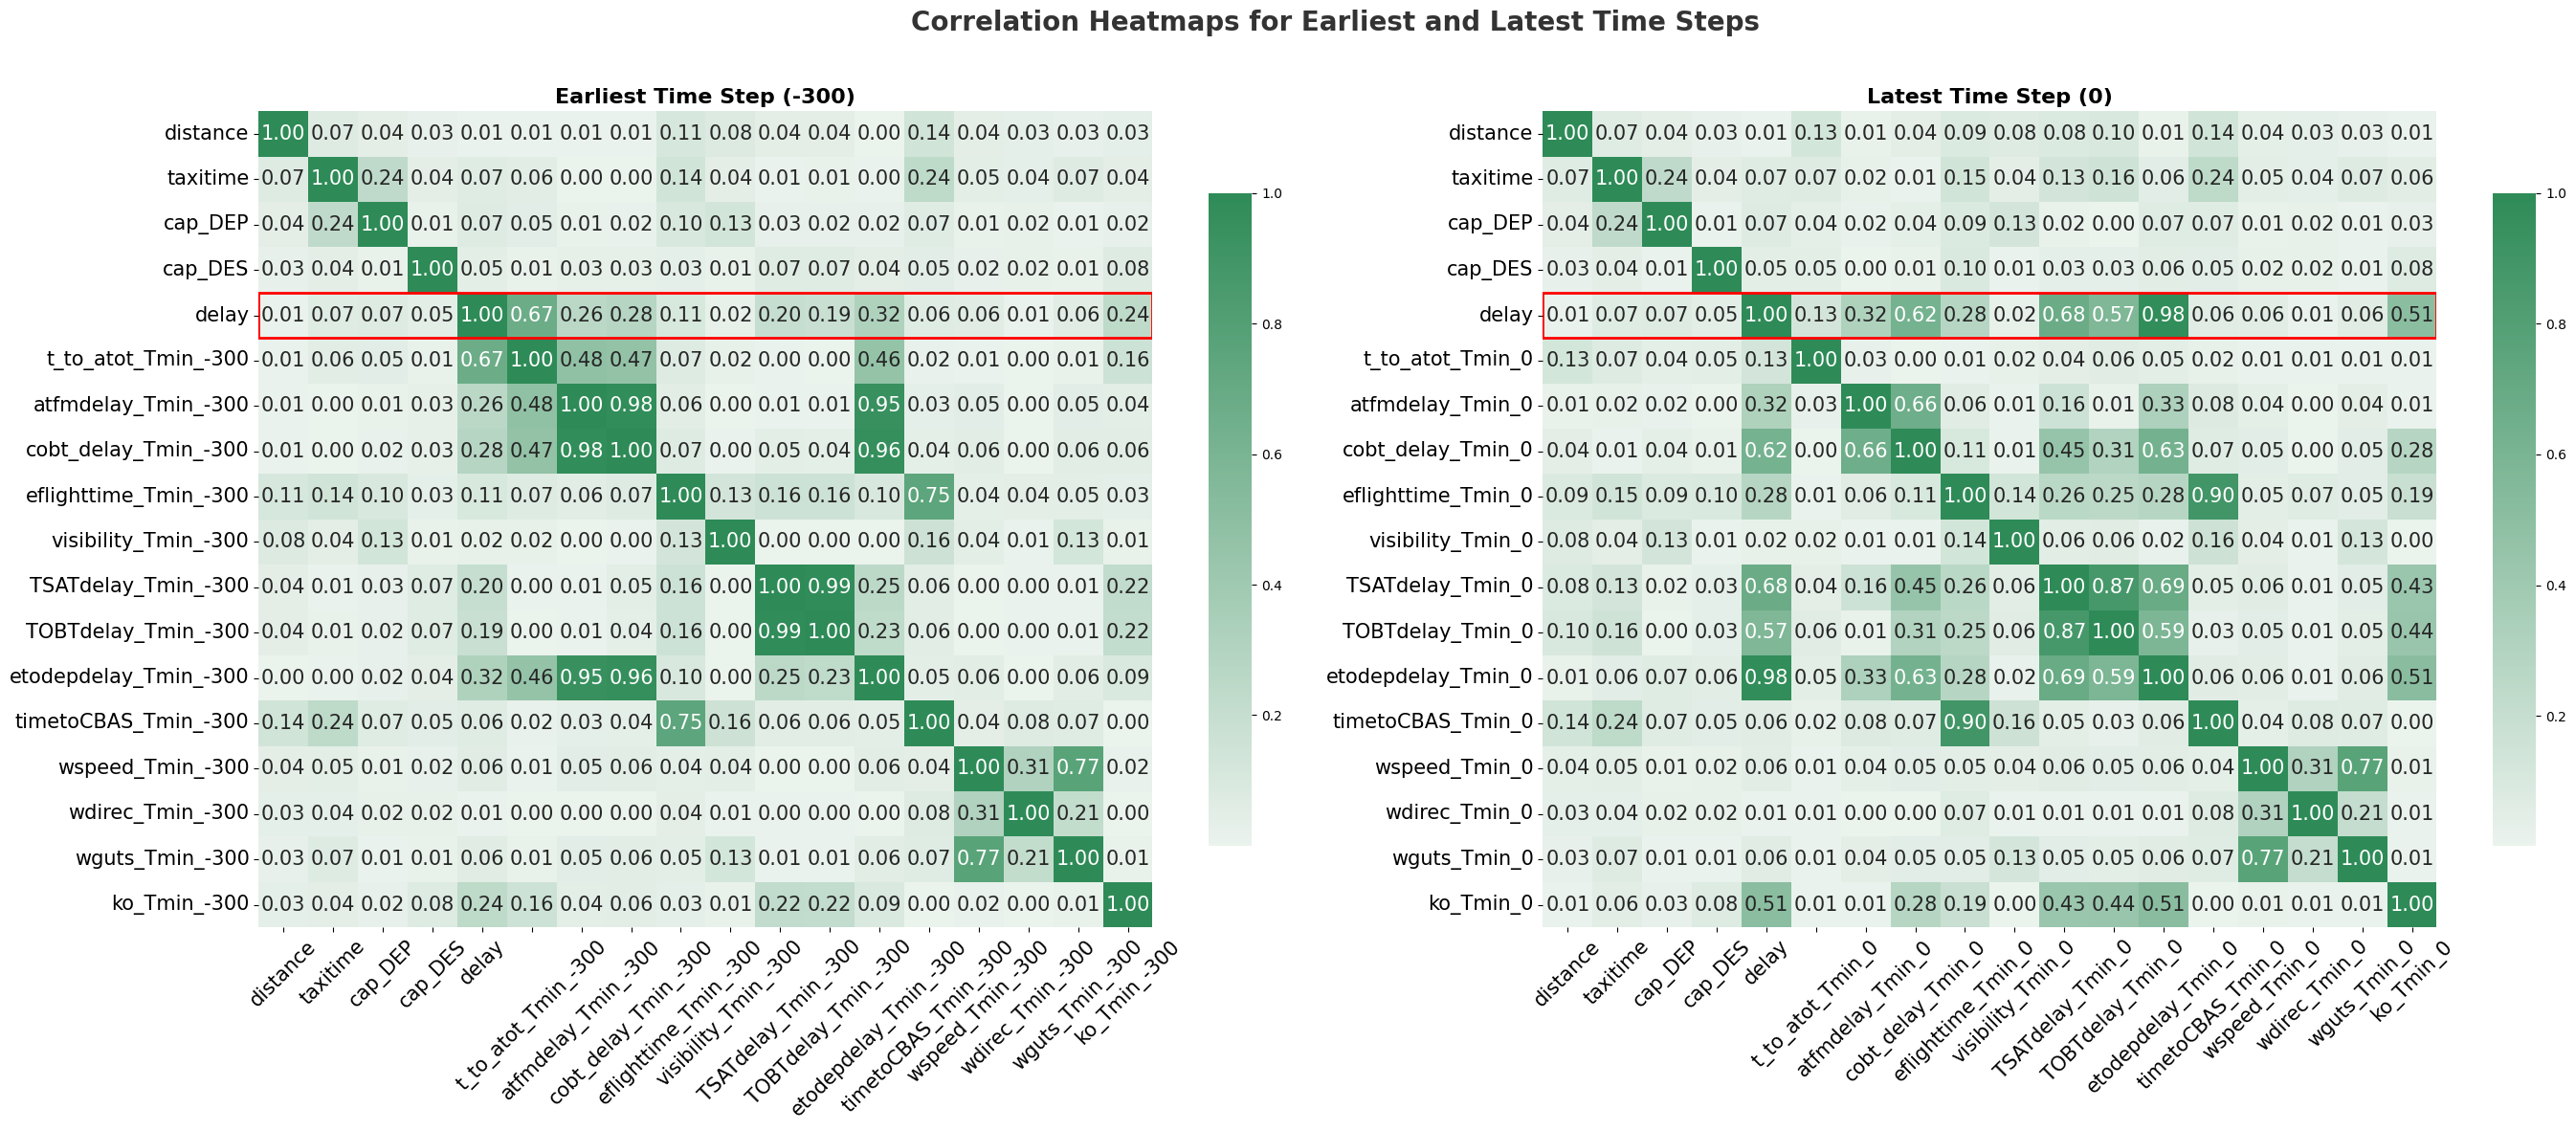

In [8]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# Plot correlation heatmaps
extended_df['ko_Tmin_-300'] = extended_df['ko1_Tmin_-300']
extended_df['ko_Tmin_0'] = extended_df['ko1_Tmin_0']
extended_df = extended_df.drop(['ko1_Tmin_-300', 'ko1_Tmin_0', 'ko2_Tmin_0','ko2_Tmin_-300'], axis=1)

plot_correlation_heatmap(extended_df, include_fixed=True)

Earliest Pattern: _Tmin_-300
Latest Pattern: _Tmin_0


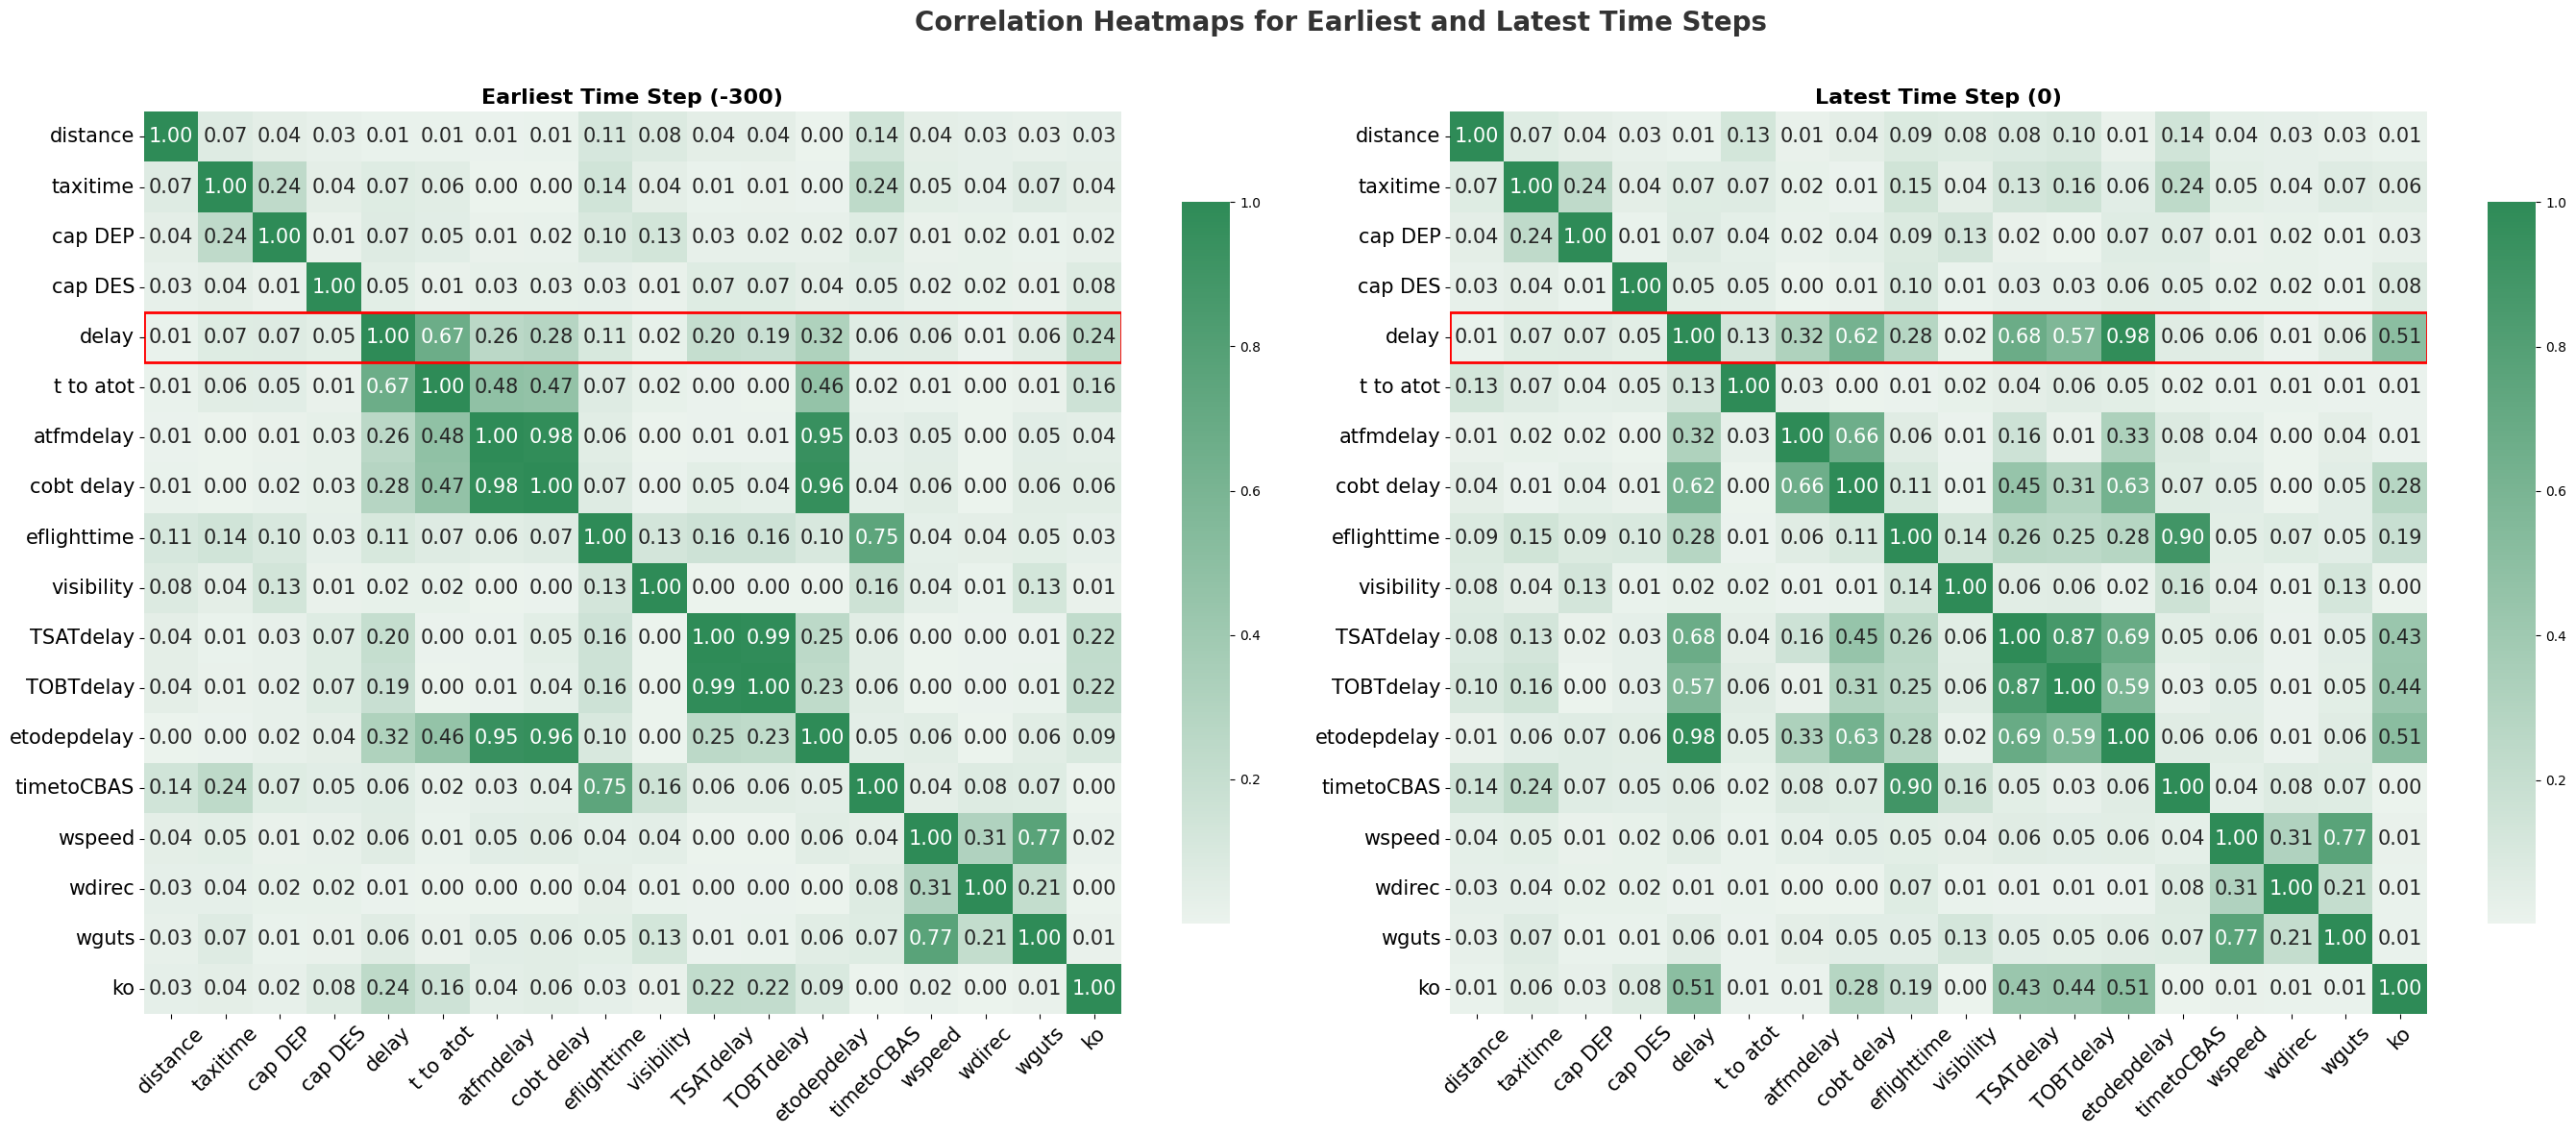

In [16]:
plot_correlation_heatmap(extended_df, include_fixed=True)